In [ ]:
pip install ipywidgets

# Extract /Dezip data

In [1]:
from zipfile import ZipFile
filename ="./hymenoptera_data.zip"
with ZipFile(filename,'r') as zip:
    zip.extractall('my_dataset')
    print('done')

done


# Importe relevant library

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
plt.ion() 

ModuleNotFoundError: No module named 'torch'

# What is the size of our image dataset

In [3]:
train_data =pd.read_csv("train.csv")

In [4]:
from PIL import Image

im = Image.open("./my_dataset/hymenoptera_data/train/ants/0013035.jpg")
width, height = im.size
print("W=>{} pixels\n\nH=>{} pixels".format(width,height))

W=>768 pixels

H=>512 pixels


In [5]:
train_data.shape[0]

22184

# Transformation

In [6]:

_image_size = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


#  Dataset + DataLoader

In [7]:
data_dir ='./my_dataset/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders ={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                             shuffle=True,
                                             num_workers=4)
                  for x in  ['train','val']}


dataset_size={x:len(image_datasets[x]) for x in ['train','val']}

class_names =image_datasets['train'].classes
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 244
     Root location: ./my_dataset/hymenoptera_data/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'val': Dataset ImageFolder
     Number of datapoints: 153
     Root location: ./my_dataset/hymenoptera_data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

# Visualizing image

In [16]:
def show(image,title=None):
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)

In [26]:
inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

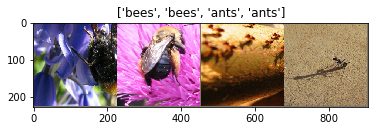

In [28]:
imshow(out, title=[class_names[x] for x in classes])

# Create the model

In [29]:

from torchvision import models

model = models.resnet18(pretrained=True)

In [30]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [31]:
#!pip install torchsummary

import torchsummary

torchsummary.summary(model, (3, 224, 224), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [32]:
# %load my_train_helper.py
def get_trainable(model_params):
    return (p for p in model_params if p.requires_grad)
    
        
def get_frozen(model_params):
    return (p for p in model_params if not p.requires_grad)
    
    
def all_trainable(model_params):
    return all(p.requires_grad for p in model_params)
    

def all_frozen(model_params):
    return all(not p.requires_grad for p in model_params)
  

def freeze_all(model_params):
    for param in model_params:
        param.requires_grad = False

In [33]:

# Freeze all parameters manually
for param in model.parameters():
    param.requires_grad = False

In [34]:
# Or use our convenient functions from before
freeze_all(model.parameters())
assert all_frozen(model.parameters())

# Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()


# Optimizer


In [ ]:
optimizer = torch.optim.Adam(
    get_trainable(model.parameters()),
    lr=0.001,
    # momentum=0.9,
)

In [ ]:
# import torch.optim as optim

# # create your optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.001)

In [57]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [58]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [59]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model_ft = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [60]:
num_ftrs

512

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5775 Acc: 0.7049
val Loss: 0.2877 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.5107 Acc: 0.8033
val Loss: 0.4858 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.5895 Acc: 0.7377
val Loss: 0.2497 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.3548 Acc: 0.8484
val Loss: 0.2047 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.3352 Acc: 0.8361
val Loss: 0.2804 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.4398 Acc: 0.8197
val Loss: 0.2543 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4138 Acc: 0.8115
val Loss: 0.2053 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.2566 Acc: 0.8934
val Loss: 0.2053 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3254 Acc: 0.8525
val Loss: 0.2885 Acc: 0.9150

Epoch 9/24
----------
train Loss: 0.3237 Acc: 0.8689
val Loss: 0.2219 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3183 Acc: 0.8607
val Loss: 0.2854 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.4563 Acc: 0.8115
val Loss: 0.2233 Acc: 0.9281

Ep